# Auto Density

## Import and Load

In [139]:
import pandas as pd
import numpy as np
import datetime
from scipy.stats import variation
import warnings
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import io
import base64
from jinja2 import Template
import mpld3
import folium
import os
from scipy.spatial import QhullError
from scipy.spatial import ConvexHull
from ipywidgets import interact, widgets
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets, Layout, interactive_output
from IPython.display import display, Javascript, HTML
from ipywidgets import interactive_output
import logging
# import ipyleaflet


In [140]:
# Set the file name and directories
input_directory = r'C:\Users\aaron.eades\OneDrive - Liquid Environmental Solutions\Documents\Programing\Python\Automated Density\Sit_LOB Files'
output_file_directory = r'C:\Users\aaron.eades\OneDrive - Liquid Environmental Solutions\Documents\Programing\Python\Automated Density\exports'
output_file_directory = r'C:\Users\aaron.eades\OneDrive - Liquid Environmental Solutions\Documents\Programing\Python\Automated Density\exports'
output_HTML_file_directory = r'C:\Users\aaron.eades\OneDrive - Liquid Environmental Solutions\Documents\Programing\Python\Automated Density\exports'

# Load the data from the Excel file
input_file = os.path.join(input_directory, f'{file_name}.xlsx')
df = pd.read_excel(input_file, sheet_name='Sheet1')

# Set the index after ensuring the column exists
# print("Columns in df before setting index:", df.columns.tolist())
# df.columns = df.columns.str.strip()  # Remove any whitespace
df.set_index('ACCOUNT #', inplace=True)
# print("Index set to 'ACCOUNT #'.")

## The Cockpit
![Alt Text](https://img.freepik.com/premium-photo/closeup-view-aircraft-cockpits-control-panel-with-glowing-displays-gauges_936494-6661.jpg)

In [141]:
#════════════════════════════════════════════════════════════════════════╗
#                          __CHANGE_HERE__                               ║
file_name = '20241009_1722_POR1'
predict = 16                                                            
high_volume_threshold = 40000                                           
volume_weight = 0.99                                                   
cluster_weight = 0.01                                                   
max_weeks_before = 2                                                    
max_weeks_after = 1                                                     
min_move_freq = 6                                                       
avg_customers_per_cluster = 6
lat_weight = 3
long_weight = 3
random_state = 42
#                                                                        ║
#════════════════════════════════════════════════════════════════════════╝

## Functions

### Helper Functions

In [142]:
output_buffer = io.StringIO()
weekCodes = [str(i) for i in range(1, predict + 1)]

def capture_print(text):
    print(text)
    output_buffer.write(text + '\n')

def fig_to_html(fig):
    return mpld3.fig_to_html(fig)

# Function to convert folium map to HTML
def map_to_html(m):
    if m:
        return m._repr_html_()
    return ""

warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

def calculate_cv(projection):
    weekly_totals = projection.sum()
    return variation(weekly_totals)

def calculate_adjusted_source_nsd(source_nsd, frequency):
    if source_nsd >= 1:
        return source_nsd
    else:
        return max(1, (source_nsd - 1) % frequency + 1)

def create_customer_projection(start_week, frequency, gallons):
    projection = pd.Series(0, index=weekCodes)
    for week in range(start_week, predict + 1, frequency):
        if week <= predict:
            projection[str(week)] = gallons
    return projection

def calculate_initial_weekly_totals(df, updated_source_nsd):
    initial_totals = {week: 0 for week in weekCodes}
    for customer, row in df.iterrows():
        start_week = updated_source_nsd.get(customer, row['Source_NSD'])
        for week in range(start_week, predict + 1, row['FREQ']):
            if week <= predict:
                initial_totals[str(week)] += row['GALLONS']
    return pd.Series(initial_totals)

def create_difference_frequency_table(df):
    # Create a cross-tabulation of FREQ and Difference
    diff_freq_table = pd.crosstab(df['FREQ'], df['Difference'])
    
    # Ensure all difference columns (-2 to 2) exist
    for diff in range(max_weeks_before * -1, max_weeks_after + 1):
        if diff not in diff_freq_table.columns:
            diff_freq_table[diff] = 0
    
    # Sort columns
    diff_freq_table = diff_freq_table.sort_index(axis=1)
    
    # Calculate row totals and percentages
    diff_freq_table['Grand Total'] = diff_freq_table.sum(axis=1)
    total = diff_freq_table['Grand Total'].sum()
    diff_freq_table['Percentage'] = (diff_freq_table['Grand Total'] / total * 100).round(2)
    
    # Calculate column totals
    grand_total_row = diff_freq_table.sum().to_frame().T
    grand_total_row.index = ['Grand Total']
    diff_freq_table = pd.concat([diff_freq_table, grand_total_row])
    
    # Format numbers without decimal places for integers
    for col in diff_freq_table.columns:
        if col != 'Percentage':
            diff_freq_table[col] = diff_freq_table[col].apply(lambda x: f"{x:.0f}" if x.is_integer() else f"{x:.2f}")

    # Format percentage column
    diff_freq_table['Percentage'] = diff_freq_table['Percentage'].apply(lambda x: f"{x:.2f}%")

    # Remove the index name
    diff_freq_table.index.name = None

    # Rename the columns to reflect the "Frequency"
    diff_freq_table.columns.name = 'Frequency'
    
    return diff_freq_table


### Clustering Functiom

In [151]:
def cluster_customers(df, n_clusters):
    global random_state
    if random_state is None:
        random_state = np.random.randint(0, 100)
    # Create features for the 5-day period
    for i in range(max_weeks_before*-1,  max_weeks_after+1):
        df[f'Adjusted_Source_NSD_{i:+d}'] = df['Adjusted_Source_NSD'] + i

    # Select features for clustering
    features = df[['LATITUDE', 'LONGITUDE'] + 
                  [f'Adjusted_Source_NSD_{i:+d}' for i in range(max_weeks_before*-1,  max_weeks_after+1)]].values

    # Apply weights to emphasize geographical proximity
    features[:, 0] *= 3  # Latitude
    features[:, 1] *= 3  # Longitude

    # Normalize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Perform clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, algorithm='elkan')
    df['Cluster ID'] = kmeans.fit_predict(scaled_features)

    # Assign days based on clusters
    df['Assigned Day'] = df['Cluster ID'] % 5 + 1

    # Clean up temporary columns
    df = df.drop([f'Adjusted_Source_NSD_{i:+d}' for i in range(max_weeks_before*-1,  max_weeks_after+1) if i != 0], axis=1)

    return df

def densify_clusters(df, optimized_projection, model_nsd, max_weeks_before, max_weeks_after, min_move_freq):
    for cluster_id in df['Cluster ID'].unique():
        cluster_customers = df[df['Cluster ID'] == cluster_id]
        median_start = int(np.median([model_nsd[customer] for customer in cluster_customers.index]))
        for customer in cluster_customers.index:
            current_start = model_nsd[customer]
            frequency = df.loc[customer, 'FREQ']
            adjusted_source_nsd = df.loc[customer, 'Adjusted_Source_NSD']
            
            if frequency >= min_move_freq and abs(current_start - median_start) <= max(max_weeks_before, max_weeks_after):
                new_start = np.clip(median_start, 
                                    adjusted_source_nsd - max_weeks_before,
                                    adjusted_source_nsd + max_weeks_after)
                gallons = df.loc[customer, 'GALLONS']
                optimized_projection.loc[customer] = create_customer_projection(new_start, frequency, gallons)
                model_nsd[customer] = new_start
    return optimized_projection, model_nsd

In [152]:
# def cluster_customers(df, n_clusters):
#     global random_state
#     if random_state is None:
#         random_state = np.random.randint(0, 100)
    
#     # Create features for the 5-day period
#     for i in range(max_weeks_before*-1,  max_weeks_after+1):
#         df[f'Adjusted_Source_NSD_{i:+d}'] = df['Adjusted_Source_NSD'] + i

#     # Select features for clustering
#     features = df[['LATITUDE', 'LONGITUDE'] + 
#                   [f'Adjusted_Source_NSD_{i:+d}' for i in range(max_weeks_before*-1,  max_weeks_after+1)]].values

#     # Apply weights to emphasize geographical proximity
#     features[:, 0] *= 3  # Latitude
#     features[:, 1] *= 3  # Longitude

#     # Normalize features
#     scaler = StandardScaler()
#     scaled_features = scaler.fit_transform(features)

#     # Perform clustering
#     kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, algorithm='elkan')
#     df['Cluster ID'] = kmeans.fit_predict(scaled_features)

#     # Assign days based on clusters
#     df['Assigned Day'] = df['Cluster ID'] % 5 + 1

#     # Clean up temporary columns
#     df = df.drop([f'Adjusted_Source_NSD_{i:+d}' for i in range(max_weeks_before*-1,  max_weeks_after+1) if i != 0], axis=1)

#     # Perform K-NN reassignment for clusters of size 1 or 2
#     df = reassign_small_clusters(df)

#     return df


# def reassign_small_clusters(df):
#     # Step 1: Identify small clusters (size 1 or 2)
#     small_clusters = df.groupby('Cluster ID').filter(lambda x: len(x) <= 2)
#     large_clusters = df.groupby('Cluster ID').filter(lambda x: len(x) > 2)

#     if not small_clusters.empty:
#         # Step 2: Find centroids of large clusters
#         large_cluster_centroids = large_clusters.groupby('Cluster ID')[['LATITUDE', 'LONGITUDE']].mean().values

#         # Step 3: Assign small clusters to nearest large cluster using K-NN
#         nbrs = NearestNeighbors(n_neighbors=1).fit(large_cluster_centroids)

#         for idx, small_cluster_row in small_clusters.iterrows():
#             # Compute distance to large clusters
#             small_cluster_point = small_cluster_row[['LATITUDE', 'LONGITUDE']].values.reshape(1, -1)
#             distance, nearest_cluster_idx = nbrs.kneighbors(small_cluster_point)

#             # Reassign the small cluster to the nearest large cluster
#             nearest_cluster_id = large_clusters['Cluster ID'].unique()[nearest_cluster_idx[0][0]]
#             df.at[idx, 'Cluster ID'] = nearest_cluster_id

#     return df

# def densify_clusters(df, optimized_projection, model_nsd, max_weeks_before, max_weeks_after, min_move_freq):
#     for cluster_id in df['Cluster ID'].unique():
#         cluster_customers = df[df['Cluster ID'] == cluster_id]
#         median_start = int(np.median([model_nsd[customer] for customer in cluster_customers.index]))
#         for customer in cluster_customers.index:
#             current_start = model_nsd[customer]
#             frequency = df.loc[customer, 'FREQ']
#             adjusted_source_nsd = df.loc[customer, 'Adjusted_Source_NSD']
            
#             if frequency >= min_move_freq and abs(current_start - median_start) <= max(max_weeks_before, max_weeks_after):
#                 new_start = np.clip(median_start, 
#                                     adjusted_source_nsd - max_weeks_before,
#                                     adjusted_source_nsd + max_weeks_after)
#                 gallons = df.loc[customer, 'GALLONS']
#                 optimized_projection.loc[customer] = create_customer_projection(new_start, frequency, gallons)
#                 model_nsd[customer] = new_start
#     return optimized_projection, model_nsd

### Optimization Function

In [145]:
def optimize_schedule(df, high_volume_threshold, volume_weight, cluster_weight, max_weeks_before, max_weeks_after, min_move_freq):
    optimized_projection = pd.DataFrame(0, columns=weekCodes, index=df.index)
    model_nsd = {}
    updated_source_nsd = {}
    weekly_totals = np.zeros(predict)

    sorted_customers = df.sort_values('GALLONS', ascending=False)
    high_volume_customers = sorted_customers[sorted_customers['GALLONS'] >= high_volume_threshold]
    regular_customers = sorted_customers[sorted_customers['GALLONS'] < high_volume_threshold]

    # Process high-volume customers separately
    for customer_name, row in high_volume_customers.iterrows():
        frequency = row['FREQ']
        adjusted_source_nsd = row['Adjusted_Source_NSD']
        gallons = row['GALLONS']

        best_start = int(adjusted_source_nsd)
        best_score = float('inf')

        for start_week in range(max(1, adjusted_source_nsd - max_weeks_before),
                                min(predict, adjusted_source_nsd + max_weeks_after) + 1):
            temp_weekly_totals = weekly_totals.copy()
            for week in range(start_week, predict + 1, frequency):
                if week <= predict:
                    temp_weekly_totals[week - 1] += gallons

            # Calculate normalized volume score (using coefficient of variation)
            volume_cv = np.std(temp_weekly_totals) / np.mean(temp_weekly_totals)
            volume_score = volume_cv / (volume_cv + 1)  # Normalize to 0-1 range

            # Calculate normalized cluster score
            cluster_distances = [abs(start_week - nsd) for nsd in cluster_customers['Adjusted_Source_NSD']]
            avg_cluster_distance = np.mean(cluster_distances)
            max_possible_distance = predict  # Maximum possible distance
            cluster_score = avg_cluster_distance / max_possible_distance

            combined_score = volume_weight * volume_score + cluster_weight * cluster_score

            if combined_score < best_score:
                best_score = combined_score
                best_start = start_week

        optimized_projection.loc[customer_name] = create_customer_projection(best_start, frequency, gallons)
        model_nsd[customer_name] = best_start
        updated_source_nsd[customer_name] = adjusted_source_nsd

        for week in range(best_start, predict + 1, frequency):
            if week <= predict:
                weekly_totals[week - 1] += gallons

    clusters = regular_customers.groupby('Cluster ID')
    for cluster_id, cluster_customers in clusters:
        best_cluster_start = int(np.median(cluster_customers['Adjusted_Source_NSD']))
        best_score = float('inf')
        base_weekly_totals = weekly_totals.copy()

        for start_week in range(max(1, best_cluster_start - max_weeks_before),
                                min(predict, best_cluster_start + max_weeks_after) + 1):
            temp_weekly_totals = base_weekly_totals.copy()
            for customer_name in cluster_customers.index:
                frequency = cluster_customers.loc[customer_name, 'FREQ']
                gallons = cluster_customers.loc[customer_name, 'GALLONS']
                for week in range(start_week, predict + 1, frequency):
                    if week <= predict:
                        temp_weekly_totals[week - 1] += gallons

            # Calculate normalized volume score (using coefficient of variation)
            volume_cv = np.std(temp_weekly_totals) / np.mean(temp_weekly_totals)
            volume_score = volume_cv / (volume_cv + 1)  # Normalize to 0-1 range

            # Calculate normalized cluster score
            cluster_distances = [abs(start_week - nsd) for nsd in cluster_customers['Adjusted_Source_NSD']]
            avg_cluster_distance = np.mean(cluster_distances)
            max_possible_distance = predict  # Maximum possible distance
            cluster_score = avg_cluster_distance / max_possible_distance

            combined_score = volume_weight * volume_score + cluster_weight * cluster_score

            if combined_score < best_score:
                best_score = combined_score
                best_cluster_start = start_week

        for customer_name in cluster_customers.index:
            frequency = cluster_customers.loc[customer_name, 'FREQ']
            gallons = cluster_customers.loc[customer_name, 'GALLONS']
            adjusted_source_nsd = cluster_customers.loc[customer_name, 'Adjusted_Source_NSD']

            if frequency >= min_move_freq:
                adjusted_start = np.clip(best_cluster_start,
                                         adjusted_source_nsd - max_weeks_before,
                                         adjusted_source_nsd + max_weeks_after)
            else:
                # Keep low-frequency customers unchanged
                adjusted_start = adjusted_source_nsd

            optimized_projection.loc[customer_name] = create_customer_projection(adjusted_start, frequency, gallons)
            model_nsd[customer_name] = adjusted_start
            updated_source_nsd[customer_name] = adjusted_source_nsd

            for week in range(adjusted_start, predict + 1, frequency):
                if week <= predict:
                    weekly_totals[week - 1] += gallons

    return optimized_projection, model_nsd, updated_source_nsd

## Optimization Process

In [146]:
# Calculate Adjusted_Source_NSD before clustering
df['Adjusted_Source_NSD'] = df.apply(
    lambda row: calculate_adjusted_source_nsd(row['Source_NSD'], row['FREQ']), axis=1)

n_clusters = len(df) // avg_customers_per_cluster  
df = cluster_customers(df, n_clusters)

# Optimize the schedule
optimized_projection, model_nsd, updated_source_nsd = optimize_schedule(
    df, high_volume_threshold, volume_weight, cluster_weight, 
    max_weeks_before, max_weeks_after, min_move_freq
)  

optimized_projection, model_nsd = densify_clusters(
    df, optimized_projection, model_nsd, max_weeks_before, max_weeks_after, min_move_freq
)

# Calculate initial weekly totals using updated Source NSD
initial_weekly_totals = calculate_initial_weekly_totals(df, updated_source_nsd)

# Convert all values to integers
optimized_projection = optimized_projection.astype(int)

# Add Source NSD, Adjusted Source NSD, and Model_NSD columns
df['Source NSD'] = df['Source_NSD']
df['Adjusted Source NSD'] = pd.Series(updated_source_nsd)
df['Model_NSD'] = pd.Series(model_nsd)

# Add the new 'Difference' column
df['Difference'] = df['Model_NSD'] - df['Adjusted Source NSD']

# Convert optimized_projection to a DataFrame with a reset index
optimized_projection_df = optimized_projection.reset_index()
optimized_projection_df = optimized_projection_df.rename(columns={'index': 'ACCOUNT #'})

# Merge the original data with the optimized projections
final_output = pd.merge(df.reset_index(), optimized_projection_df, on='ACCOUNT #', how='left')

# Create new rows for weekly totals
initial_row = pd.DataFrame({'ACCOUNT #': 'Initial Weekly Total'}, index=[0])
optimized_row = pd.DataFrame({'ACCOUNT #': 'Optimized Weekly Total'}, index=[0])
for col in final_output.columns:
    if col in weekCodes:
        initial_row[col] = initial_weekly_totals[col]
        optimized_row[col] = optimized_projection.sum()[col]
    elif col != 'ACCOUNT #':
        initial_row[col] = ''
        optimized_row[col] = ''

# Add rows for weekly totals in the final output
final_output = pd.concat([final_output, initial_row, optimized_row], ignore_index=True)

# Reorder columns
column_order = ['ACCOUNT #', 
                'Cluster ID', 
                'Source NSD', 
                'Adjusted Source NSD', 
                'Model_NSD', 
                'Difference', 
                'GALLONS', 
                'FREQ', 'LATITUDE', 'LONGITUDE'] + [col for col in final_output.columns if col not in ['ACCOUNT #', 
                                                                                   'Cluster ID', 
                                                                                   'Source NSD', 
                                                                                   'Adjusted Source NSD', 
                                                                                   'Model_NSD', 
                                                                                   'Difference', 
                                                                                   'GALLONS', 
                                                                                   'FREQ', 'LATITUDE', 'LONGITUDE']]
final_output = final_output[column_order]

## Graph and Data Output

20241009_1722_POR1

Improvement in volume volitility: 74.03%
Date & Time: 2024-10-15 13:19:49
High Volume Customer Threshold: 40000
Max Weeks Before Allowed: 2
Max Weeks After Allowed: 1
Minimum Move Frequency: 6
Average Customers Per Cluster: 6
Random State for Clustering: 42


Difference Frequency Table:
Frequency    -2   -1    0   1 Grand Total Percentage
1             0    0    1   0           1      0.15%
2             0    0   10   0          10      1.54%
3             0    0    8   0           8      1.23%
4             0    0  154   0         154     23.66%
6             0    8    4   0          12      1.84%
8             7   26   17   7          57      8.76%
10            2   11    8   7          28      4.30%
12           58   64   95  60         277     42.55%
16           17   26   22   9          74     11.37%
26            2    6    7   7          22      3.38%
52            1    0    3   4           8      1.23%
Grand Total  87  141  329  94         651    100.01%

Un

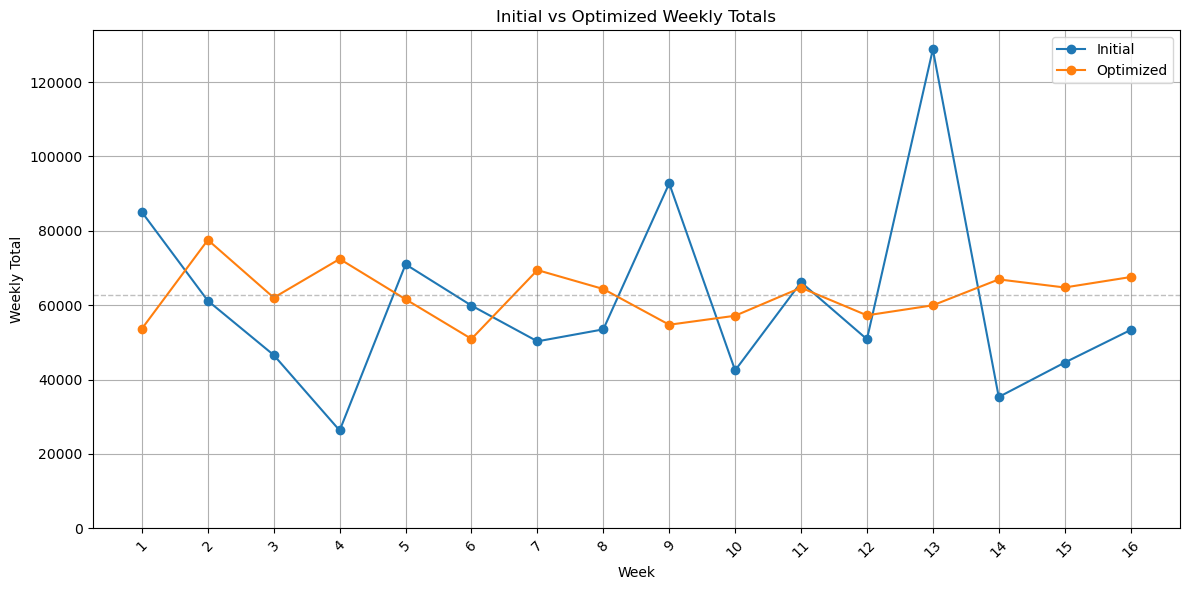

c:\Users\aaron.eades\AppData\Local\anaconda3\Lib\site-packages\mpld3\mplexporter\exporter.py:84: UserWarning: Blended transforms not yet supported. Zoom behavior may not work as expected.
  warnings.warn("Blended transforms not yet supported. "


In [147]:
capture_print(file_name)

# Calculate and print the improvement
total_variation_before = initial_weekly_totals.max() - initial_weekly_totals.min()
total_variation_after = optimized_projection.sum().max() - optimized_projection.sum().min()
improvement = (total_variation_before - total_variation_after) / total_variation_before * 100
capture_print(f"\nImprovement in volume volitility: {improvement:.2f}%")

current_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
capture_print(f"Date & Time: {current_time}\n"
              f"High Volume Customer Threshold: {high_volume_threshold}\n"
              f"Max Weeks Before Allowed: {max_weeks_before}\n"
              f"Max Weeks After Allowed: {max_weeks_after}\n"
              f"Minimum Move Frequency: {min_move_freq}\n"
              f"Average Customers Per Cluster: {avg_customers_per_cluster}\n"
              f"Random State for Clustering: {random_state}\n")

# Generate and print the difference frequency table
diff_freq_table = create_difference_frequency_table(df)
capture_print("\nDifference Frequency Table:")
capture_print(diff_freq_table.to_string())
# Calculate the number of changed and unchanged accounts
unchanged_count = (df['Difference'] == 0).sum()
changed_count = len(df) - unchanged_count
# Calculate percentages
total_accounts = len(df)
unchanged_percentage = (unchanged_count / total_accounts) * 100
changed_percentage = (changed_count / total_accounts) * 100
# Print the new statistics
capture_print(f"\nUnchanged accounts: {unchanged_count} ({unchanged_percentage:.2f}%)")
capture_print(f"Changed accounts: {changed_count} ({changed_percentage:.2f}%)")

# Create a line graph comparing initial and optimized weekly totals
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(weekCodes, initial_weekly_totals, label='Initial', marker='o')
ax.plot(weekCodes, optimized_projection.sum(), label='Optimized', marker='o')
ax.set_xlabel('Week')
ax.set_ylabel('Weekly Total')
ax.set_title('Initial vs Optimized Weekly Totals')
ax.legend()
ax.grid(False)
mean_optimized = optimized_projection.sum().mean()
ax.axhline(y=mean_optimized, color='gray', linestyle='--', label=f'Mean: {mean_optimized:.2f}', alpha=0.5, lw=1)
plt.ylim(0)
plt.xticks(rotation=45)
ax.grid(True)
plt.tight_layout()
plt.show()
line_graph_html = fig_to_html(fig)

## Map

In [153]:
global_center = None
global_zoom = 9
global_base_layer = 'OpenStreetMap'

def create_map_with_polygons(df, start_week, optimized_projection, show_polygons=True):
    global global_center, global_zoom, global_base_layer

    weeks = [str(start_week), str(start_week + 1)]
    week_customers = df[optimized_projection[weeks].sum(axis=1) > 0]
    
    if week_customers.empty:
        print(f"No customers found for weeks {start_week} and {start_week + 1}")
        return None
    
    all_locations = list(zip(df['LATITUDE'], df['LONGITUDE']))
    
    if global_center is None:
        center_lat = sum(lat for lat, _ in all_locations) / len(all_locations)
        center_lon = sum(lon for _, lon in all_locations) / len(all_locations)
        global_center = [center_lat, center_lon]
    
    # Create the map using the global center and the current base layer
    m = folium.Map(location=global_center, zoom_start=global_zoom, tiles=base_layers[global_base_layer]['url'], attr=base_layers[global_base_layer]['attr'])

    # Add all base layers to the map
    for name, layer_info in base_layers.items():
        if name != global_base_layer:  # Skip the default layer as it's already added
            folium.TileLayer(
                tiles=layer_info['url'],
                name=name,
                attr=layer_info['attr'],
                overlay=False,
                control=True
            ).add_to(m)

    # Create FeatureGroup for polygons
    polygon_group = folium.FeatureGroup(name="Polygons")

    unique_clusters = week_customers['Cluster ID'].unique()
    orange_shades = generate_color_gradient('Oranges', len(unique_clusters), start=0.6, stop=0.8)
    blue_shades = generate_color_gradient('Blues', len(unique_clusters), start=0.6, stop=0.8)

    cluster_color_mapping = {cluster_id: (orange_shades[i], blue_shades[i]) for i, cluster_id in enumerate(unique_clusters)}

    # Add scatter points for each customer (markers will always be visible)
    for idx, row in week_customers.iterrows():
        for i, week in enumerate(weeks):
            if optimized_projection.loc[idx, week] > 0:
                color = cluster_color_mapping[row['Cluster ID']][i]
                folium.CircleMarker(
                    location=[row['LATITUDE'], row['LONGITUDE']],
                    radius=2.2,
                    tooltip=(f"Account #: {idx}<br>"
                             f"Cluster ID: {row['Cluster ID']}<br>"
                             f"Name: {row['Location_Name']}<br>" 
                             f"Frequency: {row['FREQ']}<br>"
                             f"Actual NSD: {row['Adjusted_Source_NSD']}<br>"
                             f"Model NSD: {row['Model_NSD']}<br>"
                             f"Gallons: {row['GALLONS']}"),
                    color=color,
                    fill=True,
                    fillColor=color,
                    fillOpacity=0.7
                ).add_to(m)

    # Add polygons around clusters to the polygon group
    if show_polygons:
        first_week_customers = df[optimized_projection[str(start_week)] > 0]
        for cluster_id in first_week_customers['Cluster ID'].unique():
            cluster_customers = first_week_customers[first_week_customers['Cluster ID'] == cluster_id]
            cluster_points = cluster_customers[['LATITUDE', 'LONGITUDE']].values
            
            if len(cluster_points) > 2:  # Need at least 3 points to form a polygon
                try:
                    hull = ConvexHull(cluster_points, qhull_options='QJ')
                    hull_points = cluster_points[hull.vertices]
                    polygon_points = [[lat, lon] for lat, lon in hull_points]
                    
                    # Choose the orange color for polygons
                    folium.Polygon(
                        locations=polygon_points,
                        color=cluster_color_mapping[cluster_id][0],
                        fill=True,
                        fillOpacity=0.1,
                        weight=1
                    ).add_to(polygon_group)
                except QhullError:
                    print(f"Unable to create convex hull for cluster {cluster_id} in week {start_week}")
                    continue

    # Add the polygon group to the map
    polygon_group.add_to(m)

    # Add a LayerControl to toggle the visibility of polygons
    folium.LayerControl(collapsed=False).add_to(m)

    # Add a legend (optional: customize this if needed)
    legend_html = '''
         <div style="position: fixed; 
                     bottom: 50px; left: 50px; width: 120px; height: 90px; 
                     border:2px solid grey; z-index:9999; font-size:14px;
                     ">&nbsp; <b>Week Legend</b> <br>
                      &nbsp; Week {}: <i class="fa fa-circle fa-1x" style="color:orange"></i><br>
                      &nbsp; Week {}: <i class="fa fa-circle fa-1x" style="color:blue"></i>
         </div>
         '''.format(start_week, start_week + 1)
    m.get_root().html.add_child(folium.Element(legend_html))

    # Add a custom JavaScript to capture zoom and center changes
    m.add_child(folium.JavascriptLink("https://cdnjs.cloudflare.com/ajax/libs/jquery/3.6.0/jquery.min.js"))
    m.add_child(folium.Element("""
        <script>
        var map = $(".folium-map").data("leaflet-map");
        map.on('zoomend moveend baselayerchange', function(e) {
            var zoom = map.getZoom();
            var center = map.getCenter();
            var centerLat = center.lat.toFixed(6);
            var centerLng = center.lng.toFixed(6);
            var baseLayer = '';
            map.eachLayer(function(layer) {
                if (layer instanceof L.TileLayer && map.hasLayer(layer)) {
                    baseLayer = layer.options.name;
                }
            });
            window.parent.postMessage({
                'type': 'map_update',
                'zoom': zoom,
                'center': [centerLat, centerLng],
                'baseLayer': baseLayer
            }, '*');
        });
        </script>
    """))
    return m

def display_map_with_polygons(start_week, show_polygons):
    global global_zoom, global_center
    m = create_map_with_polygons(df, start_week, optimized_projection, show_polygons)
    if m:
        display(m)
        
        # Display additional information
        week_customers = df[optimized_projection[[str(start_week), str(start_week + 1)]].sum(axis=1) > 0]
        total_gallons = week_customers['GALLONS'].sum()
        customer_count = len(week_customers)
        print(f"Week {start_week} and {start_week + 1} Summary:")
        print(f"Number of customers: {customer_count}")
        print(f"Total gallons: {total_gallons}")
    else:
        print("No map to display.")

def handle_map_update(message):
    global global_zoom, global_center, global_base_layer
    global_zoom = message['zoom']
    global_center = message['center']
    global_base_layer = message['baseLayer']

# Create widgets
week_selector = widgets.IntSlider(min=1, max=16, step=1, value=1, description='Starting Week:')
polygon_toggle = widgets.Checkbox(value=True, description='Show Polygons')

# Create left and right buttons to control the slider
def on_click_left(b):
    if week_selector.value > week_selector.min:
        week_selector.value -= 1

def on_click_right(b):
    if week_selector.value < week_selector.max:
        week_selector.value += 1

button_left = widgets.Button(description='◀')
button_right = widgets.Button(description='▶')
button_left.on_click(on_click_left)
button_right.on_click(on_click_right)

# Create a horizontal box for navigation buttons
nav_box = widgets.HBox([button_left, week_selector, button_right])

# Create a vertical box for all widgets
widget_box = widgets.VBox([nav_box, polygon_toggle])

# Function to initialize and display the interactive map
def initialize_interactive_map():
    # Display widgets
    display(widget_box)
    
    # Use interact to link the widgets to the map display
    output = interactive_output(display_map_with_polygons, {'start_week': week_selector, 'show_polygons': polygon_toggle})
    
    # Display the output
    display(output)

    # Register the message handler
    display(Javascript("""
        window.addEventListener('message', function(event) {
            IPython.notebook.kernel.execute_interactive(
                "handle_map_update(" + JSON.stringify(event.data) + ")",
                { silent: false, store_history: false, stop_on_error: true }
            );
        }, false);
    """))

# Call this function to set up the interactive map
initialize_interactive_map()

Output()

<IPython.core.display.Javascript object>

## Itterate

In [108]:
# # Number of iterations to run
# iterations = 10

# warnings.filterwarnings("ignore", message="The default value of `n_init` will change from 10 to 'auto' in 1.4")


# # Log file to store results for each iteration
# log_file = os.path.join(output_file_directory, f"optimization_log_{file_name}.txt")

# # Open the log file in append mode
# with open(log_file, 'w') as log:
#     for i in range(iterations):
#         # Reset random_state for each iteration (None will generate a new random state)
#         random_state = None

#         # Rerun the clustering and optimization process
#         n_clusters = len(df) // avg_customers_per_cluster  
#         df = cluster_customers(df, n_clusters)

#         # Optimize the schedule
#         optimized_projection, model_nsd, updated_source_nsd = optimize_schedule(
#             df, high_volume_threshold, volume_weight, cluster_weight, 
#             max_weeks_before, max_weeks_after, min_move_freq
#         )  

#         optimized_projection, model_nsd = densify_clusters(
#             df, optimized_projection, model_nsd, max_weeks_before, max_weeks_after, min_move_freq
#         )

#         # Calculate initial weekly totals using updated Source NSD
#         initial_weekly_totals = calculate_initial_weekly_totals(df, updated_source_nsd)

#         # Convert all values to integers
#         optimized_projection = optimized_projection.astype(int)

#         # Add Source NSD, Adjusted Source NSD, and Model_NSD columns
#         df['Source NSD'] = df['Source_NSD']
#         df['Adjusted Source NSD'] = pd.Series(updated_source_nsd)
#         df['Model_NSD'] = pd.Series(model_nsd)

#         # Add the new 'Difference' column
#         df['Difference'] = df['Model_NSD'] - df['Adjusted Source NSD']

#         # Convert optimized_projection to a DataFrame with a reset index
#         optimized_projection_df = optimized_projection.reset_index()
#         optimized_projection_df = optimized_projection_df.rename(columns={'index': 'ACCOUNT #'})

#         # Merge the original data with the optimized projections
#         final_output = pd.merge(df.reset_index(), optimized_projection_df, on='ACCOUNT #', how='left')

#         # Calculate the improvement
#         total_variation_before = initial_weekly_totals.max() - initial_weekly_totals.min()
#         total_variation_after = optimized_projection.sum().max() - optimized_projection.sum().min()
#         improvement = (total_variation_before - total_variation_after) / total_variation_before * 100

#         # Log the results for this iteration
#         log.write(f"Iteration {i+1}/{iterations}\n")
#         log.write(f"File: {file_name}\n")
#         log.write(f"Improvement in volume volatility: {improvement:.2f}%\n")
        
#         current_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
#         log.write(f"Date & Time: {current_time}\n")
#         log.write(f"High Volume Customer Threshold: {high_volume_threshold}\n")
#         log.write(f"Max Weeks Before Allowed: {max_weeks_before}\n")
#         log.write(f"Max Weeks After Allowed: {max_weeks_after}\n")
#         log.write(f"Minimum Move Frequency: {min_move_freq}\n")
#         log.write(f"Average Customers Per Cluster: {avg_customers_per_cluster}\n")
#         log.write(f"Random State for Clustering: {random_state}\n")

#         # Generate and log the difference frequency table
#         diff_freq_table = create_difference_frequency_table(df)
#         log.write("\nDifference Frequency Table:\n")
#         log.write(diff_freq_table.to_string())
#         log.write("\n")

#         # Calculate the number of changed and unchanged accounts
#         unchanged_count = (df['Difference'] == 0).sum()
#         changed_count = len(df) - unchanged_count

#         # Log the statistics for this iteration
#         total_accounts = len(df)
#         unchanged_percentage = (unchanged_count / total_accounts) * 100
#         changed_percentage = (changed_count / total_accounts) * 100
#         log.write(f"\nUnchanged accounts: {unchanged_count} ({unchanged_percentage:.2f}%)\n")
#         log.write(f"Changed accounts: {changed_count} ({changed_percentage:.2f}%)\n")
#         log.write(f"End of Iteration {i+1}/{iterations}\n\n")

# print(f"Optimization results logged in {log_file}")


Optimization results logged in C:\Users\aaron.eades\OneDrive - Liquid Environmental Solutions\Documents\Programing\Python\Automated Density\exports\optimization_log_20241009_1722_POR1.txt


## Logging results


Improvement in volume volatility: 76.00%
Date & Time: 2024-10-15 13:17:58
High Volume Customer Threshold: 40000
Max Weeks Before Allowed: 2
Max Weeks After Allowed: 1
Minimum Move Frequency: 6
Average Customers Per Cluster: 6
Random State for Clustering: 57

Difference Frequency Table:
Frequency    -2  -1    0   1 Grand Total Percentage
1             0   0    1   0           1      0.15%
2             0   0   10   0          10      1.54%
3             0   0    8   0           8      1.23%
4             0   0  154   0         154     23.66%
6             0   6    6   0          12      1.84%
8             6   6   40   5          57      8.76%
10            2   4   20   2          28      4.30%
12            8  30  201  38         277     42.55%
16            8   8   48  10          74     11.37%
26            0   2   17   3          22      3.38%
52            0   1    7   0           8      1.23%
Grand Total  24  57  512  58         651    100.01%

Unchanged accounts: 512 (78.65%)
Ch

NameError: name 'save_graph' is not defined

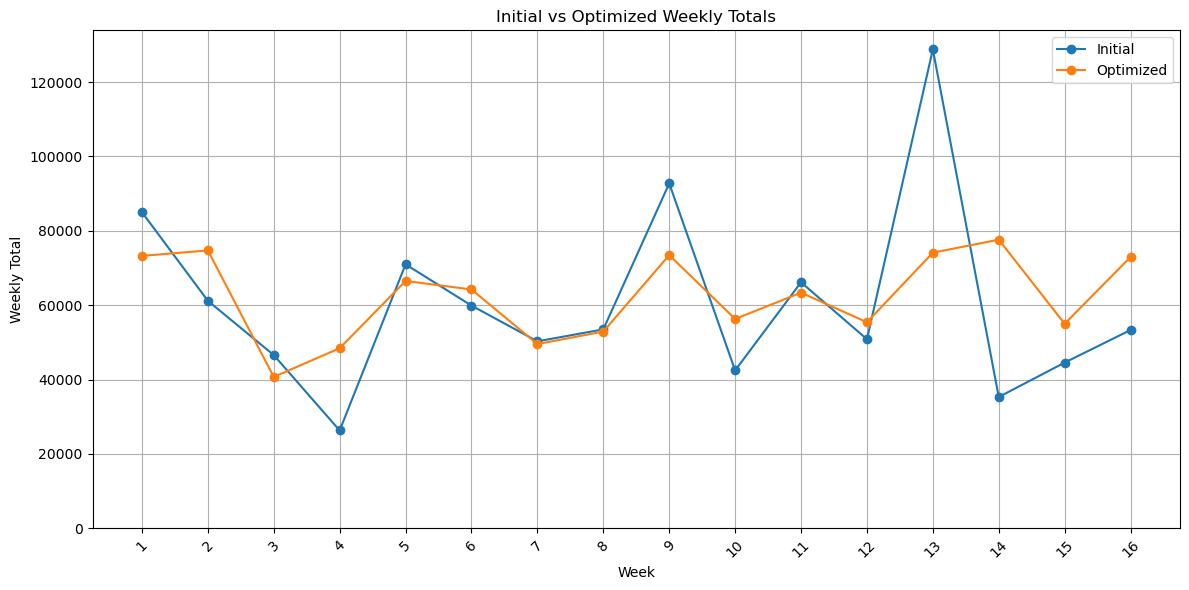

In [110]:
# Create the log directory and set up the log file in append mode
log_directory = "logs_and_outputs"
if not os.path.exists(log_directory):
    os.makedirs(log_directory)

log_filename = os.path.join(log_directory, "clustering_logs.log")
logging.basicConfig(filename=log_filename, filemode='a', level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')

# Function to capture both print and logging output
def capture_log(text):
    print(text)  # Also print to the console (optional)
    logging.info(text)  # Log to file

# Example: Log Improvement
improvement = 76.00  # Example improvement value
capture_log(f"\nImprovement in volume volatility: {improvement:.2f}%")

# Example: Log Date and Thresholds
current_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
capture_log(f"Date & Time: {current_time}")
capture_log(f"High Volume Customer Threshold: {high_volume_threshold}")
capture_log(f"Max Weeks Before Allowed: {max_weeks_before}")
capture_log(f"Max Weeks After Allowed: {max_weeks_after}")
capture_log(f"Minimum Move Frequency: {min_move_freq}")
capture_log(f"Average Customers Per Cluster: {avg_customers_per_cluster}")
capture_log(f"Random State for Clustering: {random_state}")

# Example: Log Difference Frequency Table
diff_freq_table = create_difference_frequency_table(df)
capture_log("\nDifference Frequency Table:")
capture_log(diff_freq_table.to_string())  # Log DataFrame as a string

# Example: Log Changed and Unchanged Accounts
unchanged_count = (df['Difference'] == 0).sum()
changed_count = len(df) - unchanged_count
total_accounts = len(df)
unchanged_percentage = (unchanged_count / total_accounts) * 100
changed_percentage = (changed_count / total_accounts) * 100

# Log the new statistics
capture_log(f"\nUnchanged accounts: {unchanged_count} ({unchanged_percentage:.2f}%)")
capture_log(f"Changed accounts: {changed_count} ({changed_percentage:.2f}%)")


# Create a line graph comparing initial and optimized weekly totals
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(weekCodes, initial_weekly_totals, label='Initial', marker='o')
ax.plot(weekCodes, optimized_projection.sum(), label='Optimized', marker='o')
ax.set_xlabel('Week')
ax.set_ylabel('Weekly Total')
ax.set_title('Initial vs Optimized Weekly Totals')
ax.legend()
plt.ylim(0)
plt.xticks(rotation=45)
ax.grid(True)
plt.tight_layout()

# Save the graph
save_graph(fig, "weekly_totals_comparison")

# Optionally, also display it
plt.show()



## Generate HTML Output

In [1664]:
# html_template = """
# <!DOCTYPE html>
# <html lang="en">
# <head>
#     <meta charset="UTF-8">
#     <meta name="viewport" content="width=device-width, initial-scale=1.0">
#     <title>Optimization Results</title>
#     <style>
#         body {{ font-family: Arial, sans-serif; line-height: 1.6; padding: 20px; }}
#         h1, h2 {{ color: #333; }}
#         pre {{ background-color: #f4f4f4; padding: 10px; border-radius: 5px; }}
#     </style>
# </head>
# <body>
#     <h1>Optimization Summary for {file_name}</h1>
    
#     <h2>Summary of Optimization Results</h2>
#     <pre>{output}</pre>
    
#     <h2>Graph for Initial vs Optimized Weekly Totals</h2>
#     {line_graph}
    
#     <h2>Customer Distribution Comparison for Two-Week Periods</h2>
    
#     <h3>Weeks 1-2</h3>
#     {map_1_2}
    
#     <h3>Weeks 3-4</h3>
#     {map_3_4}

#     <h3>Weeks 5-6</h3>
#     {map_5_6}

#     <h3>Weeks 7-8</h3>
#     {map_7_8}

#     <h3>Weeks 9-10</h3>
#     {map_9_10}

#     <h3>Weeks 11-12</h3>
#     {map_11_12}

#     <h3>Weeks 13-14</h3>
#     {map_13_14}

#     <h3>Weeks 15-16</h3>
#     {map_15_16}
    
# </body>
# </html>
# """

# # Create maps for each week range
# map_ranges = [(1, 2), (3, 4), (5, 6), (7, 8), (9, 10), (11, 12), (13, 14), (15, 16)]
# maps = {}

# for start, end in map_ranges:
#     try:
#         maps[f"map_{start}_{end}"] = create_map_with_polygons(df, start, optimized_projection)
#     except QhullError:
#         print(f"Error creating map for weeks {start}-{end}. Skipping this map.")
#         maps[f"map_{start}_{end}"] = None

# # Convert Folium map objects to HTML strings or use placeholder
# for key, map_obj in maps.items():
#     if map_obj:
#         maps[key] = map_obj._repr_html_()
#     else:
#         maps[key] = "<p>Map not available due to an error.</p>"

# # Render the final HTML content using format
# final_html_content = html_template.format(
#     file_name=file_name,
#     output=output_buffer.getvalue(),
#     line_graph=line_graph_html,
#     map_1_2=maps["map_1_2"],
#     map_3_4=maps["map_3_4"],
#     map_5_6=maps["map_5_6"],
#     map_7_8=maps["map_7_8"],
#     map_9_10=maps["map_9_10"],
#     map_11_12=maps["map_11_12"],
#     map_13_14=maps["map_13_14"],
#     map_15_16=maps["map_15_16"]
# )


# # Create dynamic HTML file path
# output_html_file = os.path.join(output_HTML_file_directory, f"Optimization_Summary_{file_name}.html")

# # Save the final HTML content
# with open(output_html_file, 'w', encoding='utf-8') as f:
#     f.write(final_html_content)

# print(f"HTML file '{output_html_file}' has been generated.")


#  # Save the final output to CSV
# output_file = os.path.join(output_file_directory, f'output_{file_name}.csv')
# final_output.to_csv(output_file, index=False)
# print(f"File saved to: {output_file}")


KeyError: "['10'] not in index"

## Compile Files

In [27]:
# Directory containing CSV files
folder_path = r"C:\Users\aaron.eades\OneDrive - Liquid Environmental Solutions\Documents\Programing\Python\Automated Density\exports\FIles for upload"

# Output file
output_file = r"C:\Users\aaron.eades\OneDrive - Liquid Environmental Solutions\Documents\Programing\Python\Automated Density\exports\compiled_file_with_source.csv"

# Get all CSV files in the directory
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Initialize an empty list to hold dataframes
dataframes = []

# Loop through the files and append each to the dataframes list
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Add the [model_source] column with the file name
    df.insert(0, 'model_source', file)
    
    # Append the dataframe to the list
    dataframes.append(df)

# Concatenate all dataframes into one
compiled_df = pd.concat(dataframes, ignore_index=True)

# Save the compiled dataframe to a new CSV file
compiled_df.to_csv(output_file, index=False)

print(f"Compiled file with source saved to {output_file}")


Compiled file with source saved to C:\Users\aaron.eades\OneDrive - Liquid Environmental Solutions\Documents\Programing\Python\Automated Density\exports\compiled_file_with_source.csv
